In [ ]:
!pip install sqlalchemy==1.3.9
!pip install ibm_db_sa
!pip install ipython-sql

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import ibm_db
import ibm_db_dbi
import copy

%load_ext sql

## Connecting to Database

In [4]:
%sql ibm_db_sa://blg11630:jsnv%2Bw47652s064m@dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net:50000/BLUDB

In [6]:
dsn_hostname = "dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net"
dsn_uid = "blg11630"  
dsn_pwd = "jsnv+w47652s064m" 

dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "BLUDB"          
dsn_port = "50000"                
dsn_protocol = "TCPIP"

In [7]:
#Create the dsn connection string
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd)

In [8]:
#Create database connection

try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

Connected to database:  BLUDB as user:  blg11630 on host:  dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net


In [9]:
#connection for pandas
pconn = ibm_db_dbi.Connection(conn)

## Extraction and Wrangling of Data

In [10]:
%sql select TABSCHEMA, TABNAME, CREATE_TIME from SYSCAT.TABLES \
      where TABSCHEMA not in ('SYSIBM', 'SYSCAT', 'SYSSTAT', 'SYSIBMADM', 'SYSTOOLS', 'SYSPUBLIC')

 * ibm_db_sa://blg11630:***@dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net:50000/BLUDB
Done.


tabschema,tabname,create_time
BLG11630,CENSUS_DATA,2021-05-31 20:48:27.134126
BLG11630,CHICAGO_PUBLIC_SCHOOLS,2021-05-31 20:50:10.198124
BLG11630,CHICAGO_CRIME_DATA,2021-05-31 20:51:23.002158
BLG11630,TEST_CPI,2021-06-03 08:52:19.647627
BLG11630,US_TRADE_BALANCE,2021-06-11 15:57:29.578977
BLG11630,US_RETAIL_SALES,2021-06-11 15:59:44.830520
BLG11630,US_NON_FARM_EMPLOYMENT_CHANGE,2021-06-11 16:04:03.617699
BLG11630,US_NFP_RATES,2021-06-11 16:05:38.563910
BLG11630,US_ISM_SERVICES_PMI,2021-06-11 16:07:15.651780
BLG11630,US_ISM_MANUFACTURING_PMI,2021-06-11 16:08:20.068471


In [115]:
selectQuery = 'select * from FOMC_FUTURE_DATES'
future_date = pd.read_sql(selectQuery, pconn)

pred_date = future_date.iloc[0,0] 
print(pred_date)

2021-06-16


In [116]:
label = %sql select * from US_FOMC_RATES
label = pd.DataFrame(label, columns = ['Date', 'Time', 'US_FOMC_RATES'])
label.dropna(axis=0, inplace=True)

label['Year'] = pd.to_datetime(label['Date']).dt.year.astype('str') 
label['Month'] = pd.to_datetime(label['Date']).dt.month.astype('str')
label['Date_time'] = label['Year']+'-'+label['Month']
label['Date'] = label['Date'].astype('str')+' '+label['Time'].astype('str')

label['Date'] = pd.to_datetime(label['Date'])
label['Date'] = label['Date'].values.astype(np.int64) // 10 ** 9
label.drop(['Year','Month', 'Time'], 1, inplace=True)

 * ibm_db_sa://blg11630:***@dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net:50000/BLUDB
Done.


In [117]:
label.head()

,Date,US_FOMC_RATES,Date_time
0,1619636400,0.0025,2021-4
1,1615939200,0.0025,2021-3
2,1611705600,0.0025,2021-1
3,1608076800,0.0025,2020-12
4,1604534400,0.0025,2020-11


In [118]:
label1 = copy.deepcopy(label)
label1.drop(['Date'], 1, inplace=True)
label1.head()

,US_FOMC_RATES,Date_time
0,0.0025,2021-4
1,0.0025,2021-3
2,0.0025,2021-1
3,0.0025,2020-12
4,0.0025,2020-11


In [119]:
#Call up the future date and the most recent past date from the database to use to split the dataset
last_date = max(label['Date'].values)
last_date

1619636400

In [120]:
features = ['US_TRADE_BALANCE', 'US_NFP_RATES']
features_dict = {}
for feature in features:
    selectQuery = 'select * from '+ feature #Construct the query that retrieves all rows from the INSTRUCTOR table
    features_dict[feature] = pd.read_sql(selectQuery, pconn) #Execute the statement
    features_dict[feature].columns = ['Date', 'Time', feature]
    features_dict[feature].dropna(axis=0, inplace=True)

In [121]:
for value in features_dict.values():
    value['Year'] = pd.to_datetime(value['Date']).dt.year.astype('str') 
    value['Month'] = pd.to_datetime(value['Date']).dt.month.astype('str')
    value['Date_time'] = value['Year']+'-'+value['Month']
    value['Date'] = value['Date'].astype('str')+' '+value['Time'].astype('str')
    value.drop(['Year','Month','Time'], 1, inplace=True)    

In [125]:
features_dict['US_TRADE_BALANCE'].head(2)

,Date,US_TRADE_BALANCE,Date_time
0,2021-06-08 13:30:00,-68.9,2021-6
1,2021-05-04 13:30:00,-74.4,2021-5


In [124]:
features_dict['US_NFP_RATES'].head(2)

,Date,US_NFP_RATES,Date_time
0,2021-05-07 13:30:00,0.061,2021-5
1,2021-04-02 00:00:00,0.060,2021-4


In [126]:
print(features_dict['US_TRADE_BALANCE'].shape, features_dict['US_NFP_RATES'].shape)

(136, 3) (136, 3)


In [127]:
features_train = copy.deepcopy(features_dict)
for value in features:
    features_train[value]['Date'] = pd.to_datetime(features_train[value]['Date'])
    features_train[value]['Date'] = features_train[value]['Date'].values.astype(np.int64) // 10 ** 9
    features_train[value] = features_train[value].loc[features_train[value]['Date'] <= last_date]

In [128]:
print(features_train['US_NFP_RATES'].shape, features_train['US_NFP_RATES'].shape)

(134, 3) (134, 3)


In [129]:
features_predict = copy.deepcopy(features_dict)
for value in features:
    features_predict[value]['Date'] = pd.to_datetime(features_predict[value]['Date'])
    features_predict[value]['Date'] = features_predict[value]['Date'].values.astype(np.int64) // 10 ** 9
    features_predict[value] = features_predict[value].loc[features_predict[value]['Date'] > last_date]

In [130]:
print(features_predict['US_TRADE_BALANCE'])
print(features_predict['US_NFP_RATES'])

         Date  US_TRADE_BALANCE Date_time
0  1623159000             -68.9    2021-6
1  1620135000             -74.4    2021-5
           Date  US_NFP_RATES Date_time
0    1620394200         0.061    2021-5
135  1622813400         0.057    2021-6


In [131]:
for value in features_predict.values():
    value.drop(['Date','Date_time'], 1, inplace=True)

In [132]:
for value in features:
    if features_predict[value].size > 1:
        new_value = np.mean(features_predict[value].values)
        features_predict[value] = pd.DataFrame({value:[new_value]})
    else:
        continue

In [133]:
print(features_predict['US_TRADE_BALANCE'])
print(features_predict['US_NFP_RATES'])

   US_TRADE_BALANCE
0            -71.65
   US_NFP_RATES
0         0.059


In [134]:
dataset_pred = pd.concat(features_predict.values(), axis=1)
dataset_pred

,US_TRADE_BALANCE,US_NFP_RATES
0,-71.65,0.059


In [137]:
for value in features_train.values():
    value.reset_index(inplace=True, drop=True)
    value.drop('Date', 1, inplace=True)

In [143]:
features_train['US_TRADE_BALANCE'].head(2)

,US_TRADE_BALANCE,Date_time
0,-71.1,2021-4
1,-68.2,2021-3


In [144]:
features_train['US_NFP_RATES'].head(2)

,US_NFP_RATES,Date_time
0,0.060,2021-4
1,0.062,2021-3


In [140]:
dataset_train = pd.concat(features_train.values(), axis=1)
dataset_train = dataset_train.loc[:,~dataset_train.columns.duplicated()] #Get rid of duplicate columns
dataset_train.head()

,US_TRADE_BALANCE,Date_time,US_NFP_RATES
0,-71.1,2021-4,0.060
1,-68.2,2021-3,0.062
2,-66.6,2021-2,0.063
3,-68.1,2021-1,0.067
4,-63.1,2020-12,0.067


In [141]:
dataset_train = dataset_train.merge(label1, on='Date_time', how='inner')
dataset_train.drop('Date_time', 1, inplace=True)        

In [142]:
dataset_train

,US_TRADE_BALANCE,US_NFP_RATES,US_FOMC_RATES
0,-71.1,0.060,0.0025
1,-68.2,0.062,0.0025
2,-68.1,0.067,0.0025
3,-63.1,0.067,0.0025
4,-63.9,0.069,0.0025
...,...,...,...
86,-42.8,0.096,0.0025
87,-49.9,0.095,0.0025
88,-40.3,0.097,0.0025
89,-39.7,0.097,0.0025


## Prediction

In [145]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

In [146]:
N = dataset_train.iloc[:,:-1]
Z = dataset_train.iloc[:,-1].astype(str)
N_train, N_test, Z_train, Z_test = train_test_split(N, Z, test_size=0.1, random_state=1)

1


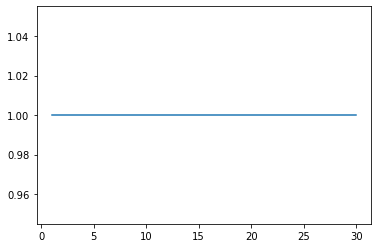

In [147]:
md_scores = {}
for md in range(1,31):  
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = md)
    loanTree.fit(N_train, Z_train)
    md_scores[md] = loanTree.score(N_test, Z_test)
opt_md = list(md_scores.keys())[list(md_scores.values()).index(max(md_scores.values()))]
print(opt_md)
sns.lineplot(x = list(md_scores.keys()), y = list(md_scores.values()))

In [148]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = opt_md)
loanTree.fit(N_train,Z_train)
ln_pred = loanTree.predict(dataset_pred)
ln_pred = ln_pred.tolist()
#ln_pred
df = pd.DataFrame({'Date':pred_date, 'FOMC Pred.':ln_pred})
df

,Date,FOMC Pred.
0,2021-06-16,0.0025


In [152]:
selectQuery = 'select * from FOMC_PRED_VALUES'
pred_tab = pd.read_sql(selectQuery, pconn)
pred_tab

,DATE,PRED_VALUE


In [163]:
if pred_date in pred_tab['DATE'].values.tolist():
    pass
else:
    query = "INSERT INTO FOMC_PRED_VALUES VALUES('{}', '{}')".format(pred_date, ln_pred[0])
    %sql $query

In [164]:
selectQuery = 'select * from FOMC_PRED_VALUES'
pred_tab = pd.read_sql(selectQuery, pconn)
pred_tab

,DATE,PRED_VALUE
0,2021-06-16,0.0025


In [ ]:
ibm_db.close(conn)